In [78]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
import bz2file as bz2

## Import dataset
leads_dataset = pd.read_csv('../Datasets/dataset.csv')
analysis_df = pd.read_csv('../Datasets/dataset.csv')
leads_dataset.columns = map(str.lower, leads_dataset.columns)

In [79]:
# Create data pre-processing steps before plugging into model
leads_categorical_columns = ['lead_source',
                             'country',
                             'gender',
                             'education_level',
                             'occupation',
                             'industry',
                             'initial_response',
                             'do_not_contact',
                             'general_knowledge',
                             'business_knowledge',
                             'company_size',
                             'lead_quality']

leads_numeric_columns = ['age',
                         'income',
                         'total_calls_attended',
                         'total_meetings_attended',
                         'company_estimated_revenue',]

leads_response_columns = ['lead_score']

In [80]:
#split data for training and testing

leads_x = leads_dataset.drop(leads_response_columns, axis=1)
leads_y = pd.DataFrame(leads_dataset[leads_response_columns])

data_train, data_test, label_train, label_test = train_test_split(leads_x,
                                                                            leads_y,
                                                                            train_size=0.9,
                                                                            test_size=0.1,
                                                                            random_state=42)

In [81]:
# Create a scaler to scale numerical features
scaler = StandardScaler()
scaler = scaler.fit(data_train[leads_numeric_columns])

In [82]:
def pre_process_leads_data(df,
                           numeric_columns,
                           categorical_columns,
                           fitted_scaler,
                           train_df_columns = None):
    ## create new df with selected columns
    df.columns = map(str.lower, df.columns)
    _df = df[list(numeric_columns + categorical_columns)].copy()

    ## scale the numeric columns with the pre-built scaler
    _df[numeric_columns] = fitted_scaler.transform(_df[numeric_columns])

    # First, make categorical text lowercase
    _df[categorical_columns] = _df[categorical_columns].apply(lambda x: x.str.lower())
    # Next, create one-hot-encoded variables, add to dataframe, drop old columns
    _df_dummies = pd.get_dummies(_df[categorical_columns])
    print(_df_dummies.head())
    _df = pd.concat([_df, _df_dummies], axis=1)

    _df.drop(categorical_columns, axis=1, inplace = True)

    if train_df_columns:
        _df = _df.reindex(columns=train_df_columns, fill_value=0)

    return _df

In [83]:
data_train_clean = pre_process_leads_data(df = data_train,
                                            numeric_columns = leads_numeric_columns,
                                            categorical_columns = leads_categorical_columns,
                                            fitted_scaler = scaler)

data_test_clean = pre_process_leads_data(df = data_test,
                                           numeric_columns = leads_numeric_columns,
                                           categorical_columns = leads_categorical_columns,
                                           fitted_scaler = scaler,
                                           train_df_columns = data_train_clean.columns.tolist())

      lead_source_inbound  lead_source_organic  lead_source_other   
4896                False                False               True  \
4782                False                False              False   
1496                False                False              False   
1957                False                False              False   
9171                False                False              False   

      lead_source_paid  lead_source_referral  country_australia   
4896             False                 False              False  \
4782              True                 False               True   
1496             False                  True              False   
1957             False                  True              False   
9171             False                  True              False   

      country_brazil  country_canada  country_china  country_france  ...   
4896           False           False          False           False  ...  \
4782           False          

In [84]:
# Train the random forest model
num_estimators = 100
min_samples = 4

rf = RandomForestClassifier(n_estimators=num_estimators,
                            min_samples_split=min_samples)
rf.fit(data_train_clean, label_train.values.ravel())

RandomForestClassifier(min_samples_split=4)

In [85]:
## Test Model Accuracy
rf_pred = rf.predict(data_test_clean)
rf_pred = pd.DataFrame(rf_pred)
rf_acc = accuracy_score(label_test, rf_pred)
rf_cnf = confusion_matrix(label_test, rf_pred)

print('Accuracy:', rf_acc)
print('Confusion Matrix:')
print(rf_cnf)

Accuracy: 0.04
Confusion Matrix:
[[1 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 2 1]
 [0 0 0 ... 1 0 0]]


In [86]:
## Train Logistic Regression Model and Check Performance
LR_clf = LogisticRegression(max_iter=1000)
LR_clf.fit(data_train_clean, label_train.values.ravel())
LR_pred = LR_clf.predict(data_test_clean)
print(type(LR_pred))
#LR_acc = accuracy_score(label_test, LR_pred)
#LR_cnf = confusion_matrix(label_test, LR_pred)
#print('Accuracy:', LR_acc)
#print('Confusion Matrix:')
#print(LR_cnf)

<class 'numpy.ndarray'>


In [87]:
gbr = GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse',
                                min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3,
                                min_impurity_decrease=0.0, init=None, random_state=None,
                                max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False,
                                validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
gbr.fit(data_train_clean, label_train.values.ravel())
gbr_pred = gbr.predict(data_test_clean)
#gbr_pred = pd.DataFrame(gbr_pred)

#gbr_acc = accuracy_score(label_test, gbr_pred)
#gbr_cnf = confusion_matrix(label_test, gbr_pred)
#print('Accuracy:', gbr_acc)
#print('Confusion Matrix:')
#print(gbr_cnf)

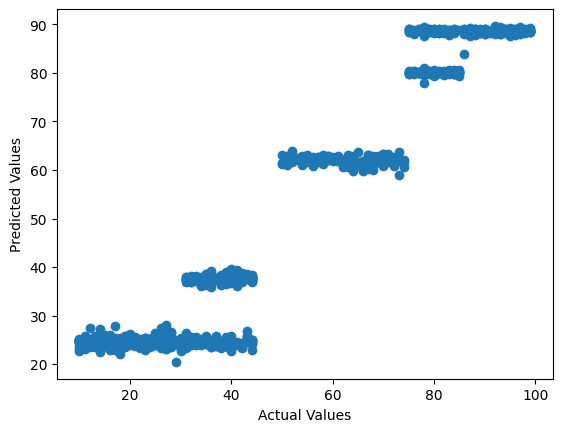

In [88]:
plt.scatter(label_test, gbr_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [89]:
print(f1_score(label_test,gbr_pred))

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [73]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(label_test, gbr_pred)
mae = mean_absolute_error(label_test, gbr_pred)
r2 = r2_score(label_test, gbr_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

Mean Squared Error: 56.65433722468619
Mean Absolute Error: 6.087577012378084
R-squared: 0.9310169515892852


In [15]:
#Dump the Model into a PKL file to add to the API
#Since Logistic Regressor performed better we pick that
#import bz2file as bz2
with bz2.BZ2File('model2' + '.pbz2', 'w') as f:
#    joblib.dump(rf, f)
    joblib.dump(rf,f)

In [16]:
#pickle.dump(scaler, open('scaler.pkl', 'wb'))
joblib.dump(scaler,'scaler2.joblib')

['scaler2.joblib']

In [75]:
joblib.dump(rf, 'rf.joblib')

['rf.joblib']

In [21]:
leads_columns = ['lead_source',
                             'country',
                             'age',
                             'gender',
                             'education_level',
                             'occupation',
                             'industry',
                             'income',
                             'initial_response',
                             'do_not_contact',
                             'total_calls_attended',
                             'total_meetings_attended',
                             'general_knowledge',
                             'business_knowledge',
                             'company_size',
                             'company_estimated_revenue',
                             'lead_quality']
lead = [
    'REFERRAL',
    'Japan',
    44,
    'OTHER',
    'HIGH SCHOOL',
    'SELF-EMPLOYED',
    'MANUFACTURING',
    87000,
    'POSITIVE',
    'No',
    5,
    3,
    'NOVICE',
    'INTERMEDIATE',
    'LARGE',
    272000,
    'HOT']

lead = pd.DataFrame([lead], columns= leads_columns)
lead[leads_categorical_columns] = lead[leads_categorical_columns].apply(lambda x: x.str.lower())
lead = pd.get_dummies(lead)
#lead.head()
#lead.head()
new_df = pd.DataFrame(columns=data_train_clean.columns)
new_df = pd.concat([new_df,lead], axis=0, ignore_index = True, sort = False)
empty_cols = new_df.columns[new_df.isnull().any()]
new_df[empty_cols] = new_df[empty_cols].fillna(False)
new_df[leads_numeric_columns] = scaler.transform(new_df[leads_numeric_columns])
print(gbr.predict(new_df))
#lead_dummy = pd.get_dummies(lead,columns=leads_categorical_columns)
#lead_dummy.head()

[64.49420125]


In [10]:
print(LR_clf.predict(new_df))

[75]


In [11]:
print(gbr_pred)

[62.88253705 78.97127875 90.21878546 ... 90.45980487 90.39356784
 90.70219529]
